In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, array, random, dot
from sklearn.model_selection import train_test_split

np.random.seed(1)

## Load data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).


In [2]:
train = pd.read_csv('../data/digit-recognizer/train.csv')
test = pd.read_csv('../data/digit-recognizer/test.csv')
print(f"Size of train dataset: {train.shape}")
print(f"Size of test dataset: {test.shape}")

Size of train dataset: (42000, 785)
Size of test dataset: (28000, 784)


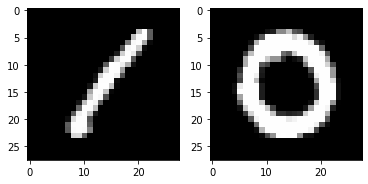

In [3]:
plt.subplot(121)
plt.imshow(np.array(train.iloc[0, 1:]).reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(np.array(train.iloc[1, 1:]).reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

## Preprocess data

Data preprocessing would include:
* Standardization (numeric values are rescaled in order to have mean=0 and standard deviation=1)
* Split the dataset on train and test datasets

In [4]:
def vectorize_y(y):
    y_vect = np.zeros((len(y), 10))
    y_vect[list(range(len(y))), y] = 1
    return y_vect


In [5]:
X = train.iloc[:, 1:]/255.0
y = vectorize_y(train.iloc[:, 0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

# or use a subset for quick run
# train_size = 500
# test_size = int(train_size*0.2)
# X_train = X_train.iloc[:train_size]
# y_train = y_train[:train_size]
# X_test = X_test.iloc[:test_size]
# y_test = y_test[:test_size]

## Build a model


THE LEARNING ALGORITHM
1. Initialize weights and biases randomly
2. Iterate over the data<br>
    i. Compute the output of neural network using sigmoid function<br>
    ii. Compute the loss using the square error loss function<br>
    iii. W(new) = W(old) — α ∆W<br>
    iv. B(new) = B(old) — α ∆B<br>
3. Repeat in order to get minimal error

In [6]:
class DigitRecognitionNN():
    def __init__(self, structure, epochs=3, learninig_rate=0.01, mini_batch_size=10):
        self.structure = structure
        self.epochs = epochs
        self.learninig_rate = learninig_rate
        self.mini_batch_size = mini_batch_size
        self.cost = []
        self.params = self.initialize()

    def initialize(self):
        params = {}
        for i in range(1, len(self.structure)):
            params[f'W{i}'] = np.random.randn(self.structure[i], self.structure[i-1]) * np.sqrt(1./self.structure[i])
            params[f'b{i}'] = np.zeros(self.structure[i])
            print(f"Initialized {i} layer: weights {params[f'W{i}'].shape}, biases {params[f'b{i}'].shape}")
        return params

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def forward_pass(self, x_train):
        self.params['A0'] = x_train
        for i in range(1, len(self.structure)):
            self.params[f'Z{i}'] = np.dot(self.params[f'W{i}'], self.params[f'A{i-1}'])
            self.params[f'Z{i}'] += self.params[f'b{i}']
            self.params[f'A{i}'] = self.sigmoid(self.params[f'Z{i}'])
        return self.params[f'A{len(self.structure)-1}']

    def backward_pass(self, x_train, y_train):
        gradients = {}
        last_gradient_index = len(self.structure)-1
        cost_derivative =  self.params[f'A{last_gradient_index}'] - y_train
        delta = cost_derivative * self.sigmoid(self.params[f'Z{last_gradient_index}'], derivative=True)
        gradients[f'W{last_gradient_index}'] = np.dot(delta, self.params[f'A{last_gradient_index}'].transpose())
        gradients[f'b{last_gradient_index}'] = delta
        for i in range(len(self.structure)-2, 0, -1):
            delta = np.dot(self.params[f'W{i+1}'].T, delta) * self.sigmoid(self.params[f'Z{i}'], derivative=True)
            gradients[f'W{i}'] = np.dot(delta, self.params[f'A{i}'].T)
            gradients[f'b{i}'] = delta
        return gradients

    def compute_accuracy(self, X, Y):
        predictions = []
        for x, y in zip(X, Y):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        return np.mean(predictions)

    def update_mini_batch(self, mini_batch_x, mini_batch_y):
        nabla_b = [np.zeros(self.params[f'b{i}'].shape) for i in range(1, len(self.structure))]
        nabla_w = [np.zeros(self.params[f'W{i}'].shape) for i in range(1, len(self.structure))]
        for x, y in zip(mini_batch_x, mini_batch_y):
            self.forward_pass(x)
            gradients = self.backward_pass(x, y)
            for i in range(1, len(self.structure)):
                nabla_b[i-1] += gradients[f'b{i}']
                nabla_w[i-1] += gradients[f'W{i}']
        for i in range(1, len(self.structure)):
            self.params[f'W{i}'] -= (self.learninig_rate/len(mini_batch_x))*nabla_w[i-1]
            self.params[f'b{i}'] -= (self.learninig_rate/len(mini_batch_y))*nabla_b[i-1]

    def train(self, x_train, y_train, x_val, y_val):
        """Train the neural network using mini-batch stochastic gradient descent"""
        n = len(x_train)
        start_time = time.time()
        for j in range(self.epochs):
            shuffle_index = np.random.permutation(n)
            training_data_x = x_train.values[shuffle_index]
            training_data_y = y_train[shuffle_index]
            mini_batches_y = [training_data_y[k:k+self.mini_batch_size]
                            for k in range(0, n, self.mini_batch_size)]
            mini_batches_x = [training_data_x[k:k+self.mini_batch_size]
                            for k in range(0, n, self.mini_batch_size)]
            for mini_batch_x, mini_batch_y in zip(mini_batches_x, mini_batches_y):
                self.update_mini_batch(mini_batch_x, mini_batch_y)
            train_accuracy = self.compute_accuracy(x_train.values, y_train)
            test_accuracy = self.compute_accuracy(x_val.values, y_val)
            print("Epoch {}. Time spent: {:.2f}. Accuracy on train set: {:.2f}%. Accuracy on test set: {:.2f}%.".format(
                j+1, time.time() - start_time, train_accuracy*100, test_accuracy*100))
        print("Finished.")


In [7]:
nn_structure = [784, 128, 64, 10] # [784, 350, 10]
drnn = DigitRecognitionNN(nn_structure, epochs=3, learninig_rate=0.01, mini_batch_size=16)
drnn.train(X_train, y_train, X_test, y_test)

Initialized 1 layer: weights (128, 784), biases (128,)
Initialized 2 layer: weights (64, 128), biases (64,)
Initialized 3 layer: weights (10, 64), biases (10,)
Epoch 1. Time spent: 40.46. Accuracy on train set: 11.02%. Accuracy on test set: 11.29%.
Epoch 2. Time spent: 84.78. Accuracy on train set: 11.09%. Accuracy on test set: 11.40%.
Epoch 3. Time spent: 132.33. Accuracy on train set: 11.12%. Accuracy on test set: 11.43%.
Finished.


## Submit the prediction

In [9]:
prediction = []
test_normalized = test.values/255.0
for x in test_normalized:
    output = drnn.forward_pass(x)
    prediction.append(np.argmax(output))
submission = pd.DataFrame({
    "ImageId": list(range(1, test.shape[0]+1)),
    "Label": prediction
})
submission.to_csv("../data/digit-recognizer/digit-recognizer-submission.csv", index=False)
submission.head()

,ImageId,Label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
